Notebook created to measure the time needed to predict the mass percentiles and metallicity of a galaxy given its spectrum

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from accelerate import Accelerator #to use pytorch
from torch.utils.data import DataLoader

from spender import SpectrumEncoder,MLP,encoder_percentiles,load_model
from tqdm import tqdm,trange

from sbi import utils as Ut
from sbi import inference as Inference


In [5]:
index_sh=np.load('./saved_models/ind_sh_balanced.npy')
seds=np.load('./saved_input/seds_short.npy') #bad, these are not
y=np.load('./saved_input/y_balanced.npy',allow_pickle=True)[index_sh[405000:][:10],:]
wave=np.load('./saved_input/wave_balanced.npy')

In [116]:
"""#reshape y

batch_size=512 

y=np.zeros((27000,10))

#to create a single dataset with all the minibatches
for j in range(len(y_b)):
    for i,x in enumerate(y_b[j]):
        y[batch_size*j+i,:]=x"""
        

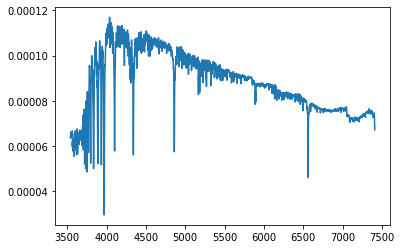

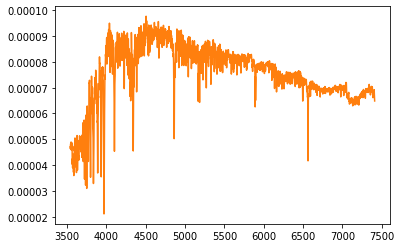

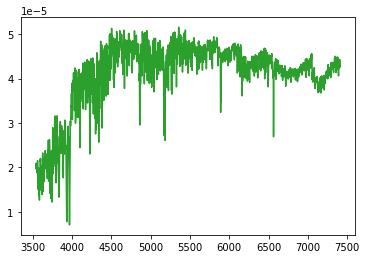

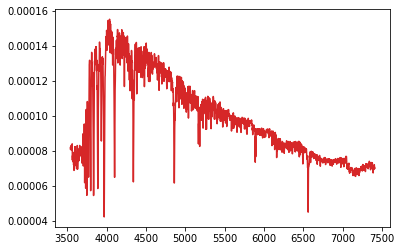

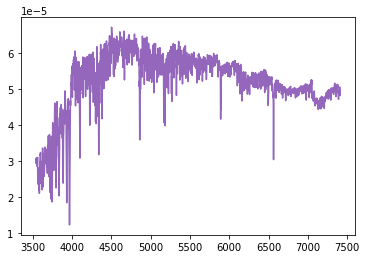

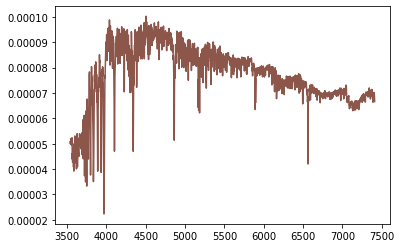

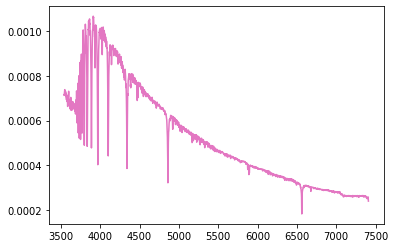

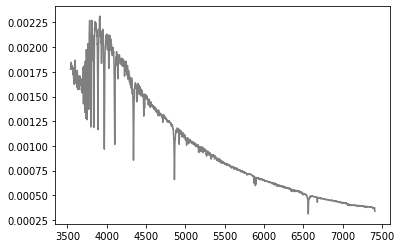

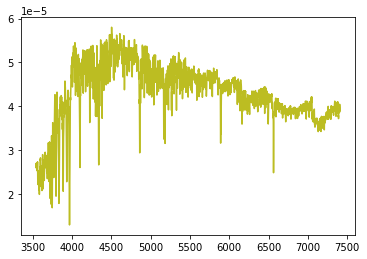

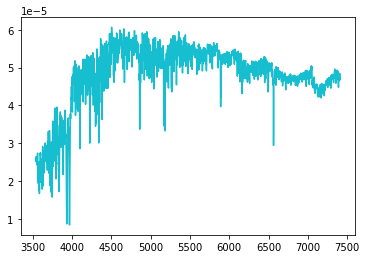

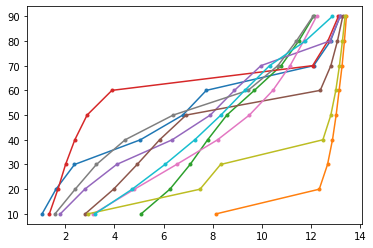

In [12]:

for i in range(10):
    plt.plot(wave, seds[i,:],c='C'+str(i))
    plt.show()

for i in range(10):
    plt.plot(y[i,:9],np.arange(10,100,10),'.-',c='C'+str(i))
plt.show()



In [90]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self,x,y):

        """ generate and organize artificial data from parametrizations of SFHs"""

        self.x=torch.from_numpy(x) #seds
        self.y=torch.from_numpy(y) #percentiles


    def __len__(self):
        """total number of samples"""
        return len(self.x[:,0])

    def __getitem__(self,index):
        """Generates one sample of data"""
        x=self.x[index,:]
        y=self.y[index,:]
        return x,y


In [91]:
#create a pytorch dataset

dataset = Dataset(seds[:1000,:], y[:1000,:])
params={'batch_size': 1 } 
generator = torch.utils.data.DataLoader(dataset,**params) #without minibatches

#call accelerator
accelerator = Accelerator(mixed_precision='fp16')
loader = accelerator.prepare(generator)

#load model
n_latent=16
model_file = "./saved_models/checkpoint_b.pt"
model, loss = load_model(model_file, device=accelerator.device,n_hidden=(16,32),n_out=11)
model = accelerator.prepare(model)
        
#predict
ss=[]
ys_=[]
print('Getting latent vectors and predicted percentiles')
with torch.no_grad():
    model.eval()
    for  batch in tqdm(loader):
                s,y_ = model._forward(batch[0].float())
                ss.append(s.cpu().numpy())
                ys_.append(y_.cpu().numpy())

ss=np.array(ss)[:,0,:]

Getting latent vectors and predicted percentiles


100%|███████████████████████████████████████| 1000/1000 [00:32<00:00, 30.33it/s]


In [36]:
file="./saved_models/my_posterior_b.pkl"

file = open(file, 'rb')
qphi = pickle.load(file)
file.close()

In [105]:
posteriors=[]


for i in trange(1000):
    posteriors.append(np.array(qphi.sample((1,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors=np.array(posteriors)[:,0,:]

100%|███████████████████████████████████████| 1000/1000 [00:19<00:00, 50.41it/s]


(1000, 10)


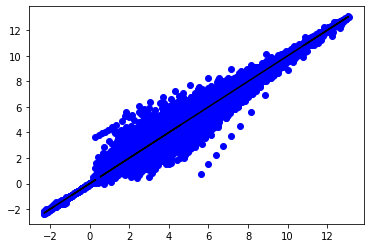

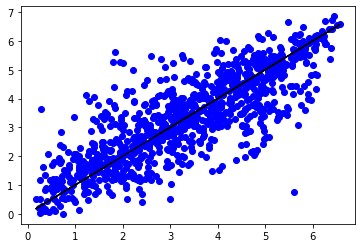

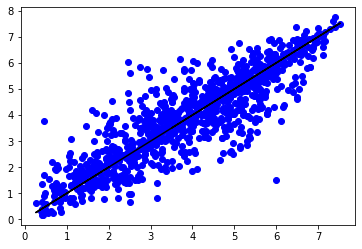

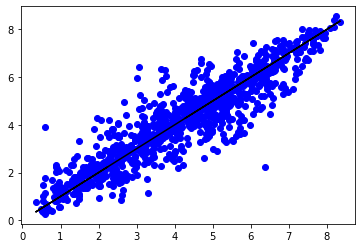

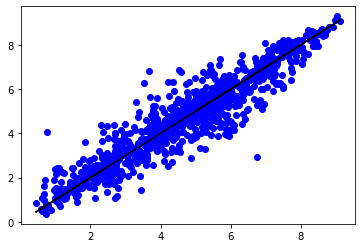

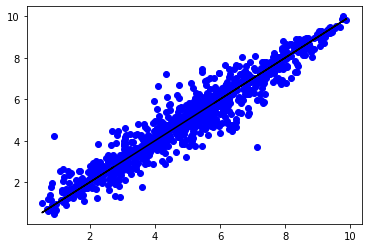

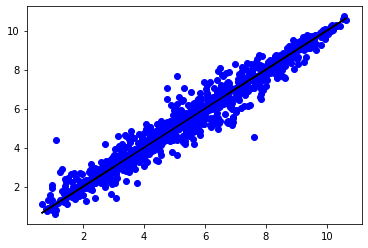

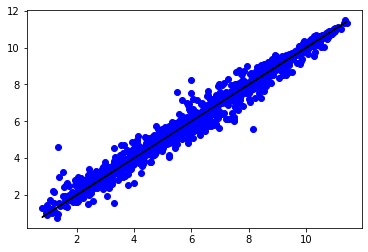

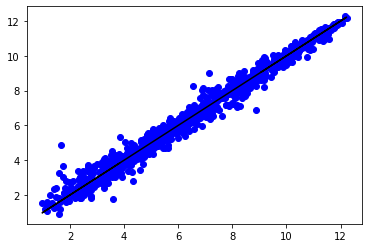

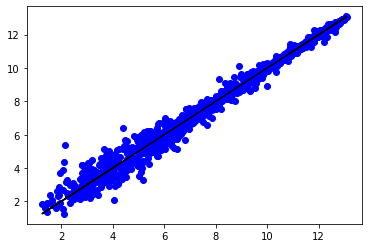

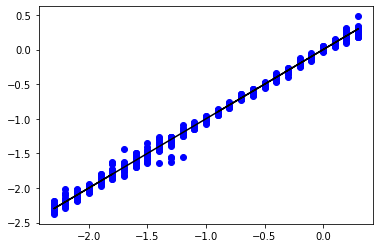

In [106]:
print(np.shape(posteriors))

for i in range(11):
    plt.plot(y[:1000,i],posteriors[:,i],'bo')
    plt.plot(y[:1000,i],y[:1000,i],'k-')
plt.show()

for i in range(11):
    plt.plot(y[:1000,i],posteriors[:,i],'bo')
    plt.plot(y[:1000,i],y[:1000,i],'k-')
    plt.show()

So, time needed to generate the latent vector:
    
32/1000=0.032 s

Time to generate a single sample (not a distribution):

19/1000= 0.019 s

In total, for a single prediction of the 9 percentiles + metallicity:

0.032 + 0.019 = 0.051 s


Right now we try to predict distributions (1000 samples)

In [111]:
posteriors_dist=[]


for i in trange(1000):
    posteriors_dist.append(np.array(qphi.sample((1000,), 
                                     x=torch.as_tensor(ss[i,:]).to('cpu'), 
                                     show_progress_bars=False).detach().to('cpu')))
posteriors_dist=np.array(posteriors_dist)

100%|███████████████████████████████████████| 1000/1000 [07:07<00:00,  2.34it/s]


Time for 1000 predictions for each galaxy:

(5*60+58) /1000 = 0.358 s

In total:

0.032+0.358= 0.39 s

(1000, 1000, 10)
(1000, 10)


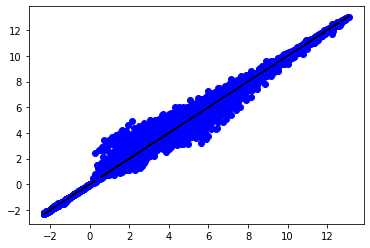

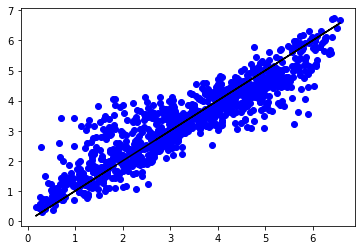

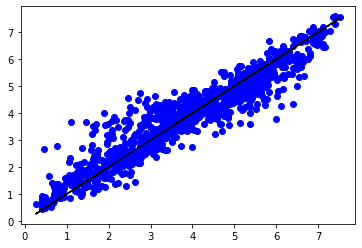

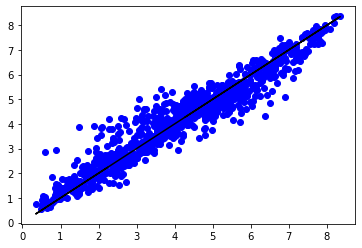

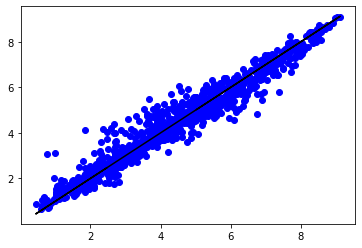

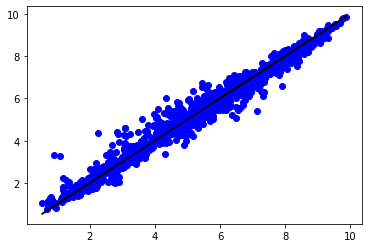

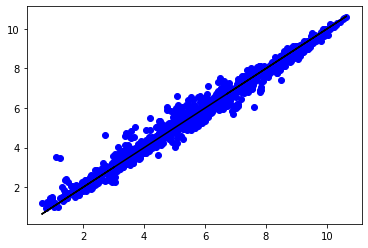

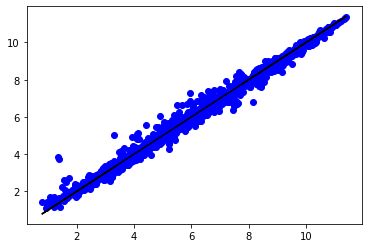

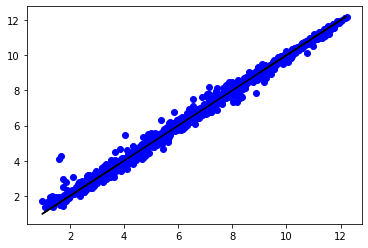

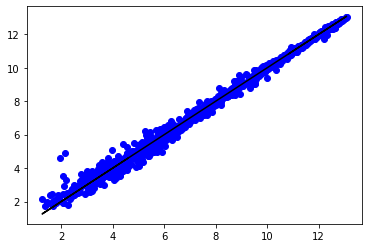

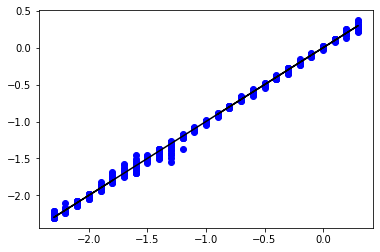

In [115]:
print(np.shape(posteriors_dist))

means=np.mean(posteriors_dist,axis=1)

print(np.shape(means))


for i in range(10):
    plt.plot(y[:1000,i],means[:,i],'bo')
    plt.plot(y[:1000,i],y[:1000,i],'k-')
plt.show()


for i in range(10):
    plt.plot(y[:1000,i],means[:,i],'bo')
    plt.plot(y[:1000,i],y[:1000,i],'k-')
    plt.show()
    